In [1]:
import time
from google.cloud import bigquery
from google.oauth2 import service_account

KEY_PATH = "mindful-vial-460001-h6-4d83b36dd3e9.json"
PROJECT  = "mindful-vial-460001-h6"
CRED     = service_account.Credentials.from_service_account_file(KEY_PATH)
client   = bigquery.Client(project=PROJECT, credentials=CRED)

start = time.perf_counter()
query = f"""
  SELECT DISTINCT customer_id
  FROM `{PROJECT}.euphoria.purchase_events_topic`
  WHERE category='merch'
    AND product_name='Authentic Mahiman Trophy'
"""
job = client.query(query)
# Wait for it to finish
job.result()
trophy_ids = [row.customer_id for row in job]
elapsed = time.perf_counter() - start

print(f"Step 1 complete: fetched {len(trophy_ids)} IDs in {elapsed:.1f}s")


Step 1 complete: fetched 591565 IDs in 17.4s


In [5]:
import time
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

# ── Auth setup ──────────────────────────────────────────────
KEY_PATH = "mindful-vial-460001-h6-4d83b36dd3e9.json"
PROJECT  = "mindful-vial-460001-h6"
CRED     = service_account.Credentials.from_service_account_file(KEY_PATH)
client   = bigquery.Client(project=PROJECT, credentials=CRED)

# ── 1) Get trophy‐buyer IDs ──────────────────────────────────
start = time.perf_counter()
sql_ids = f"""
  SELECT DISTINCT customer_id
  FROM `{PROJECT}.euphoria.purchase_events_topic`
  WHERE category='merch'
    AND product_name='Authentic Mahiman Trophy'
"""
trophy_ids = [row.customer_id for row in client.query(sql_ids)]
print(f"Fetched {len(trophy_ids)} trophy IDs in {time.perf_counter()-start:.1f}s")

# ── 2) Pull at most 50 000 profiles with correct age calc ────
start = time.perf_counter()
sql_profiles = f"""
WITH trophy_profiles AS (
  SELECT
    c.customer_id,
    DATE_DIFF(CURRENT_DATE(), DATE(c.birthday), YEAR) AS age,
    c.gender,
    c.region
  FROM `{PROJECT}.euphoria.purchase_events_topic` p
  JOIN `{PROJECT}.euphoria.customers_topic`    c
    USING(customer_id)
  WHERE p.category = 'merch'
    AND p.product_name = 'Authentic Mahiman Trophy'
)
SELECT *
FROM trophy_profiles
LIMIT 50000
"""
df_profiles = client.query(sql_profiles).to_dataframe()
print(f"Loaded {len(df_profiles)} profiles in {time.perf_counter()-start:.1f}s")
print(df_profiles.head())

# ── 3) Build, scale, and PCA ─────────────────────────────────


Fetched 591565 trophy IDs in 15.0s
Loaded 50000 profiles in 3.7s
                            customer_id  age  gender  \
0  64eb3962-40ae-4dc8-8f95-6457c8d278e0   13  Female   
1  9d2b9878-0f20-47ef-b00f-e0f6e225638c   13  Female   
2  f71f69df-6105-435c-b64e-4ff28488aff9   13  Female   
3  2e924be6-af0a-49c3-b05a-aa14eb4f09b8   13  Female   
4  6432a4e1-c6d4-47e0-b634-188bb10f9cd7   13    Male   

                             region  
0                              Laos  
1                           Iceland  
2                            Bhutan  
3  Saint Vincent and the Grenadines  
4                              Fiji  


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

# ── 3) Build, scale, and PCA ─────────────────────────────────
num = df_profiles[["age"]]

# Use sparse_output=False instead of sparse=False
ohe = OneHotEncoder(sparse_output=False, drop="first")
cat_arr = ohe.fit_transform(df_profiles[["gender", "region"]])
cat_df = pd.DataFrame(
    cat_arr,
    columns=ohe.get_feature_names_out(["gender","region"])
)
X = pd.concat([num.reset_index(drop=True), cat_df], axis=1)

# ── 4) Standardize & run PCA ─────────────────────────────────
start = time.perf_counter()
X_scaled = StandardScaler().fit_transform(X)
pca      = PCA(n_components=2, random_state=42)
X_pca    = pca.fit_transform(X_scaled)
print(f"PCA completed in {time.perf_counter()-start:.1f}s")

# ── 5) Attach & inspect ───────────────────────────────────────
df_profiles[["PC1", "PC2"]] = X_pca
print("Explained variance ratios:", pca.explained_variance_ratio_)
print("Sample PC scores:\n", df_profiles[["customer_id","PC1","PC2"]].head())


PCA completed in 0.5s
Explained variance ratios: [0.00770878 0.00543652]
Sample PC scores:
                             customer_id       PC1       PC2
0  64eb3962-40ae-4dc8-8f95-6457c8d278e0  0.001511 -0.781636
1  9d2b9878-0f20-47ef-b00f-e0f6e225638c  0.172322 -2.052093
2  f71f69df-6105-435c-b64e-4ff28488aff9 -0.165058 -1.231900
3  2e924be6-af0a-49c3-b05a-aa14eb4f09b8 -0.151354 -1.747852
4  6432a4e1-c6d4-47e0-b634-188bb10f9cd7 -1.717132 -0.591963


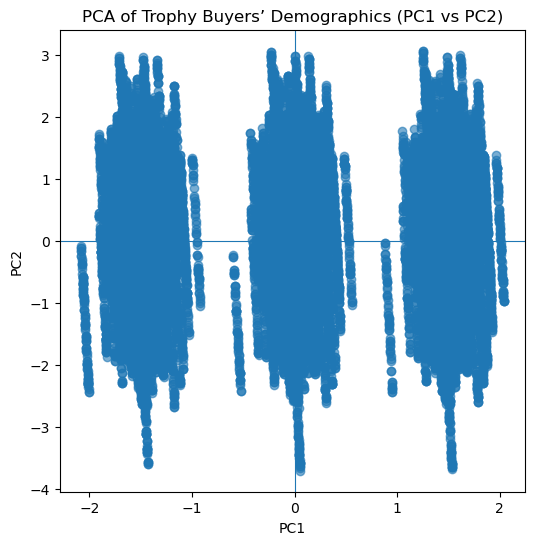

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(df_profiles['PC1'], df_profiles['PC2'], alpha=0.6)
plt.axhline(0, linewidth=0.8)
plt.axvline(0, linewidth=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Trophy Buyers’ Demographics (PC1 vs PC2)')
plt.show()


Dimension 1 inertia: 50.27%
Dimension 2 inertia: 49.73%


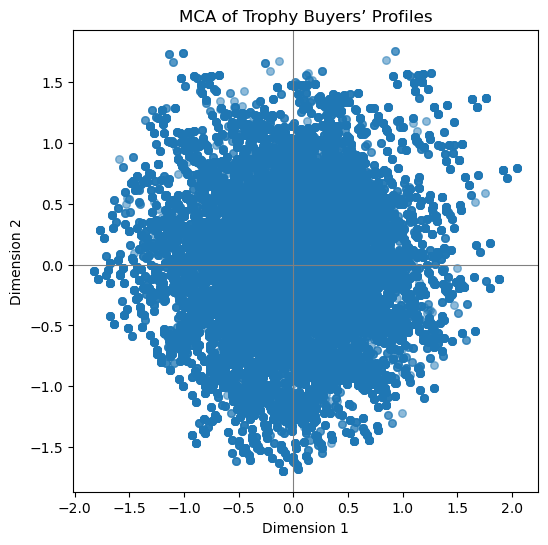

                       0         1
age_bin__10-14 -0.460616  0.766626
age_bin__15-19 -0.009673  0.434447
age_bin__20-24  0.118668  0.448854
age_bin__25-29  0.101384 -0.501670
age_bin__30-34 -0.579289 -0.033891


In [12]:
# 4) Fit & transform
mca = mca.fit(df_mca)
coords = mca.transform(df_mca)
coords.columns = ['Dim1','Dim2']

# 5) Inertia explained
eigen   = mca.eigenvalues_
inertia = eigen / eigen.sum()
print(f"Dimension 1 inertia: {inertia[0]:.2%}")
print(f"Dimension 2 inertia: {inertia[1]:.2%}")

# 6) Plot the results
plt.figure(figsize=(6,6))
plt.scatter(coords['Dim1'], coords['Dim2'], alpha=0.5, s=30)
plt.axhline(0, color='gray', lw=0.8)
plt.axvline(0, color='gray', lw=0.8)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title("MCA of Trophy Buyers’ Profiles")
plt.show()

# 7) Category loadings
loadings = mca.column_coordinates(df_mca)
print(loadings.head())


In [17]:
# rank the factor levels by their coordinate on each dimension
print(loadings[0].sort_values(ascending=False).head(5))
print(loadings[0].sort_values(ascending=True).head(5))

print(loadings[1].sort_values(ascending=False).head(5))
print(loadings[1].sort_values(ascending=True).head(5))


region__Tanzania       2.470155
region__Algeria        2.188471
region__Morocco        2.030969
region__Libya          1.975254
region__Saint Lucia    1.805165
Name: 0, dtype: float64
region__Saint Vincent and the Grenadines   -2.328113
region__Luxembourg                         -2.239940
region__India                              -2.132369
region__Albania                            -2.068122
region__Argentina                          -1.906626
Name: 0, dtype: float64
region__Libya     2.244620
region__Palau     2.218812
region__Canada    2.091046
region__Iraq      1.955754
region__Monaco    1.903478
Name: 1, dtype: float64
region__Seychelles   -2.351825
region__Venezuela    -2.211326
region__Ethiopia     -2.176675
region__Djibouti     -2.050644
region__Kazakhstan   -2.039307
Name: 1, dtype: float64


Cluster sizes:
cluster
0    12587
1    15161
2    10663
3    11589
Name: count, dtype: int64


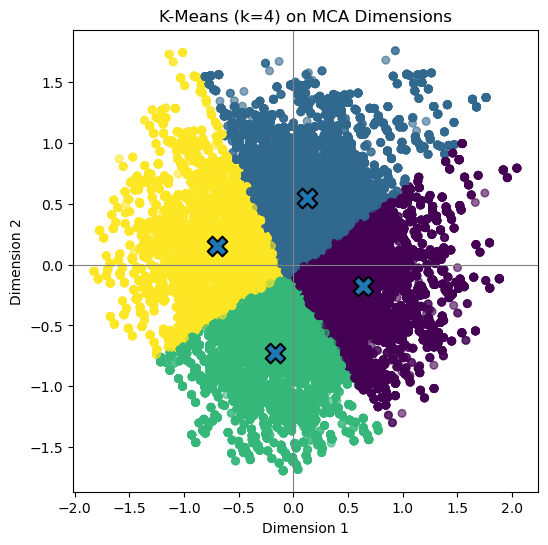

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1) Choose k and fit
k = 4
km = KMeans(n_clusters=k, random_state=42)
coords['cluster'] = km.fit_predict(coords[['Dim1', 'Dim2']])
df_profiles['cluster'] = coords['cluster']

# 2) Check cluster sizes
print("Cluster sizes:")
print(df_profiles['cluster'].value_counts().sort_index())

# 3) Plot the clusters in MCA space
plt.figure(figsize=(6,6))
plt.scatter(
    coords['Dim1'], coords['Dim2'],
    c=coords['cluster'],       # colors by cluster
    s=30, alpha=0.6
)
# Show cluster centers
centers = km.cluster_centers_
plt.scatter(
    centers[:,0], centers[:,1],
    marker='X', s=200, edgecolor='k', linewidth=1.5
)
plt.axhline(0, color='gray', lw=0.8)
plt.axvline(0, color='gray', lw=0.8)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title(f'K-Means (k={k}) on MCA Dimensions')
plt.show()
